In [1]:
import pandas as pd
import pickle

import utils.VcfHandler as VcfHandler
import utils.BranchShortening as BranchShortening
import utils.YChrDataset as YChrDataset

human_chimp_identity_cutoff = 0.981

human_chimp_identity_df = pd.read_csv('human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', sep='\t', header=None, names=['identity'])
human_chimp_identity_df['POS'] = human_chimp_identity_df.index + 1

genotype_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
genotype_data_identity_filtered = pd.merge(genotype_data, human_chimp_identity_df, on=['POS'], how='inner')
genotype_data_identity_filtered = genotype_data_identity_filtered[genotype_data_identity_filtered['identity'] >= human_chimp_identity_cutoff]

res_tmrca_afr = BranchShortening.get_tmrca_afr_and_mut_rate(genotype_data, 'Ust_Ishim', 44400, 'A00', YChrDataset.non_african_samples)
res_tmrca_afr_filtered = BranchShortening.get_tmrca_afr_and_mut_rate(genotype_data_identity_filtered, 'Ust_Ishim', 44400, 'A00', YChrDataset.non_african_samples)

pickle.dump(res_tmrca_afr, open('data/output_data/tmrca_A00_non_africans.pkl', "wb"))
pickle.dump(res_tmrca_afr_filtered, open('data/output_data/tmrca_A00_non_africans_filtered.pkl', "wb"))


In [4]:
import pandas as pd
import pickle
import numpy as np

import utils.BranchShortening as BranchShortening
import utils.YChrDataset as YChrDataset
import utils.VcfHandler as VcfHandler

human_chimp_identity_cutoff = 0.981

human_chimp_identity_df = pd.read_csv('human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', sep='\t', header=None, names=['identity'])
human_chimp_identity_df['POS'] = human_chimp_identity_df.index + 1

genotype_data = pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl')
genotype_data = VcfHandler.get_genotypes_from_vcf_dataframe(genotype_data)

genotype_data_identity_filtered = pd.merge(genotype_data, human_chimp_identity_df, on=['POS'], how='inner')
genotype_data_identity_filtered = genotype_data_identity_filtered[genotype_data_identity_filtered['identity'] >= human_chimp_identity_cutoff]

res_tmrca_afr = pickle.load(open('data/output_data/tmrca_A00_non_africans.pkl', 'rb'))
res_tmrca_afr_filtered = pickle.load(open('data/output_data/tmrca_A00_non_africans_filtered.pkl', 'rb'))

res_tmrca_chag2 = BranchShortening.get_archaic_tmrca_and_age(genotype_data, 'Chagyrskaya2', 'A00', YChrDataset.non_african_samples, res_tmrca_afr)
res_tmrca_mez2 = BranchShortening.get_archaic_tmrca_and_age(genotype_data, 'Mezmaiskaya2', 'A00', YChrDataset.non_african_samples, res_tmrca_afr)

res_tmrca_chag2_filtered = BranchShortening.get_archaic_tmrca_and_age(genotype_data_identity_filtered, 'Chagyrskaya2', 'A00', YChrDataset.non_african_samples, res_tmrca_afr_filtered)
res_tmrca_mez2_filtered = BranchShortening.get_archaic_tmrca_and_age(genotype_data_identity_filtered, 'Mezmaiskaya2', 'A00', YChrDataset.non_african_samples, res_tmrca_afr_filtered)

pickle.dump(res_tmrca_chag2, open('data/output_data/tmrca_chag2_A00_non_africans.pkl', "wb"))
pickle.dump(res_tmrca_mez2, open('data/output_data/tmrca_mez2_A00_non_africans.pkl', "wb"))

pickle.dump(res_tmrca_chag2_filtered, open('data/output_data/tmrca_chag2_A00_non_africans_filtered.pkl', "wb"))
pickle.dump(res_tmrca_mez2_filtered, open('data/output_data/tmrca_mez2_A00_non_africans_filtered.pkl', "wb"))


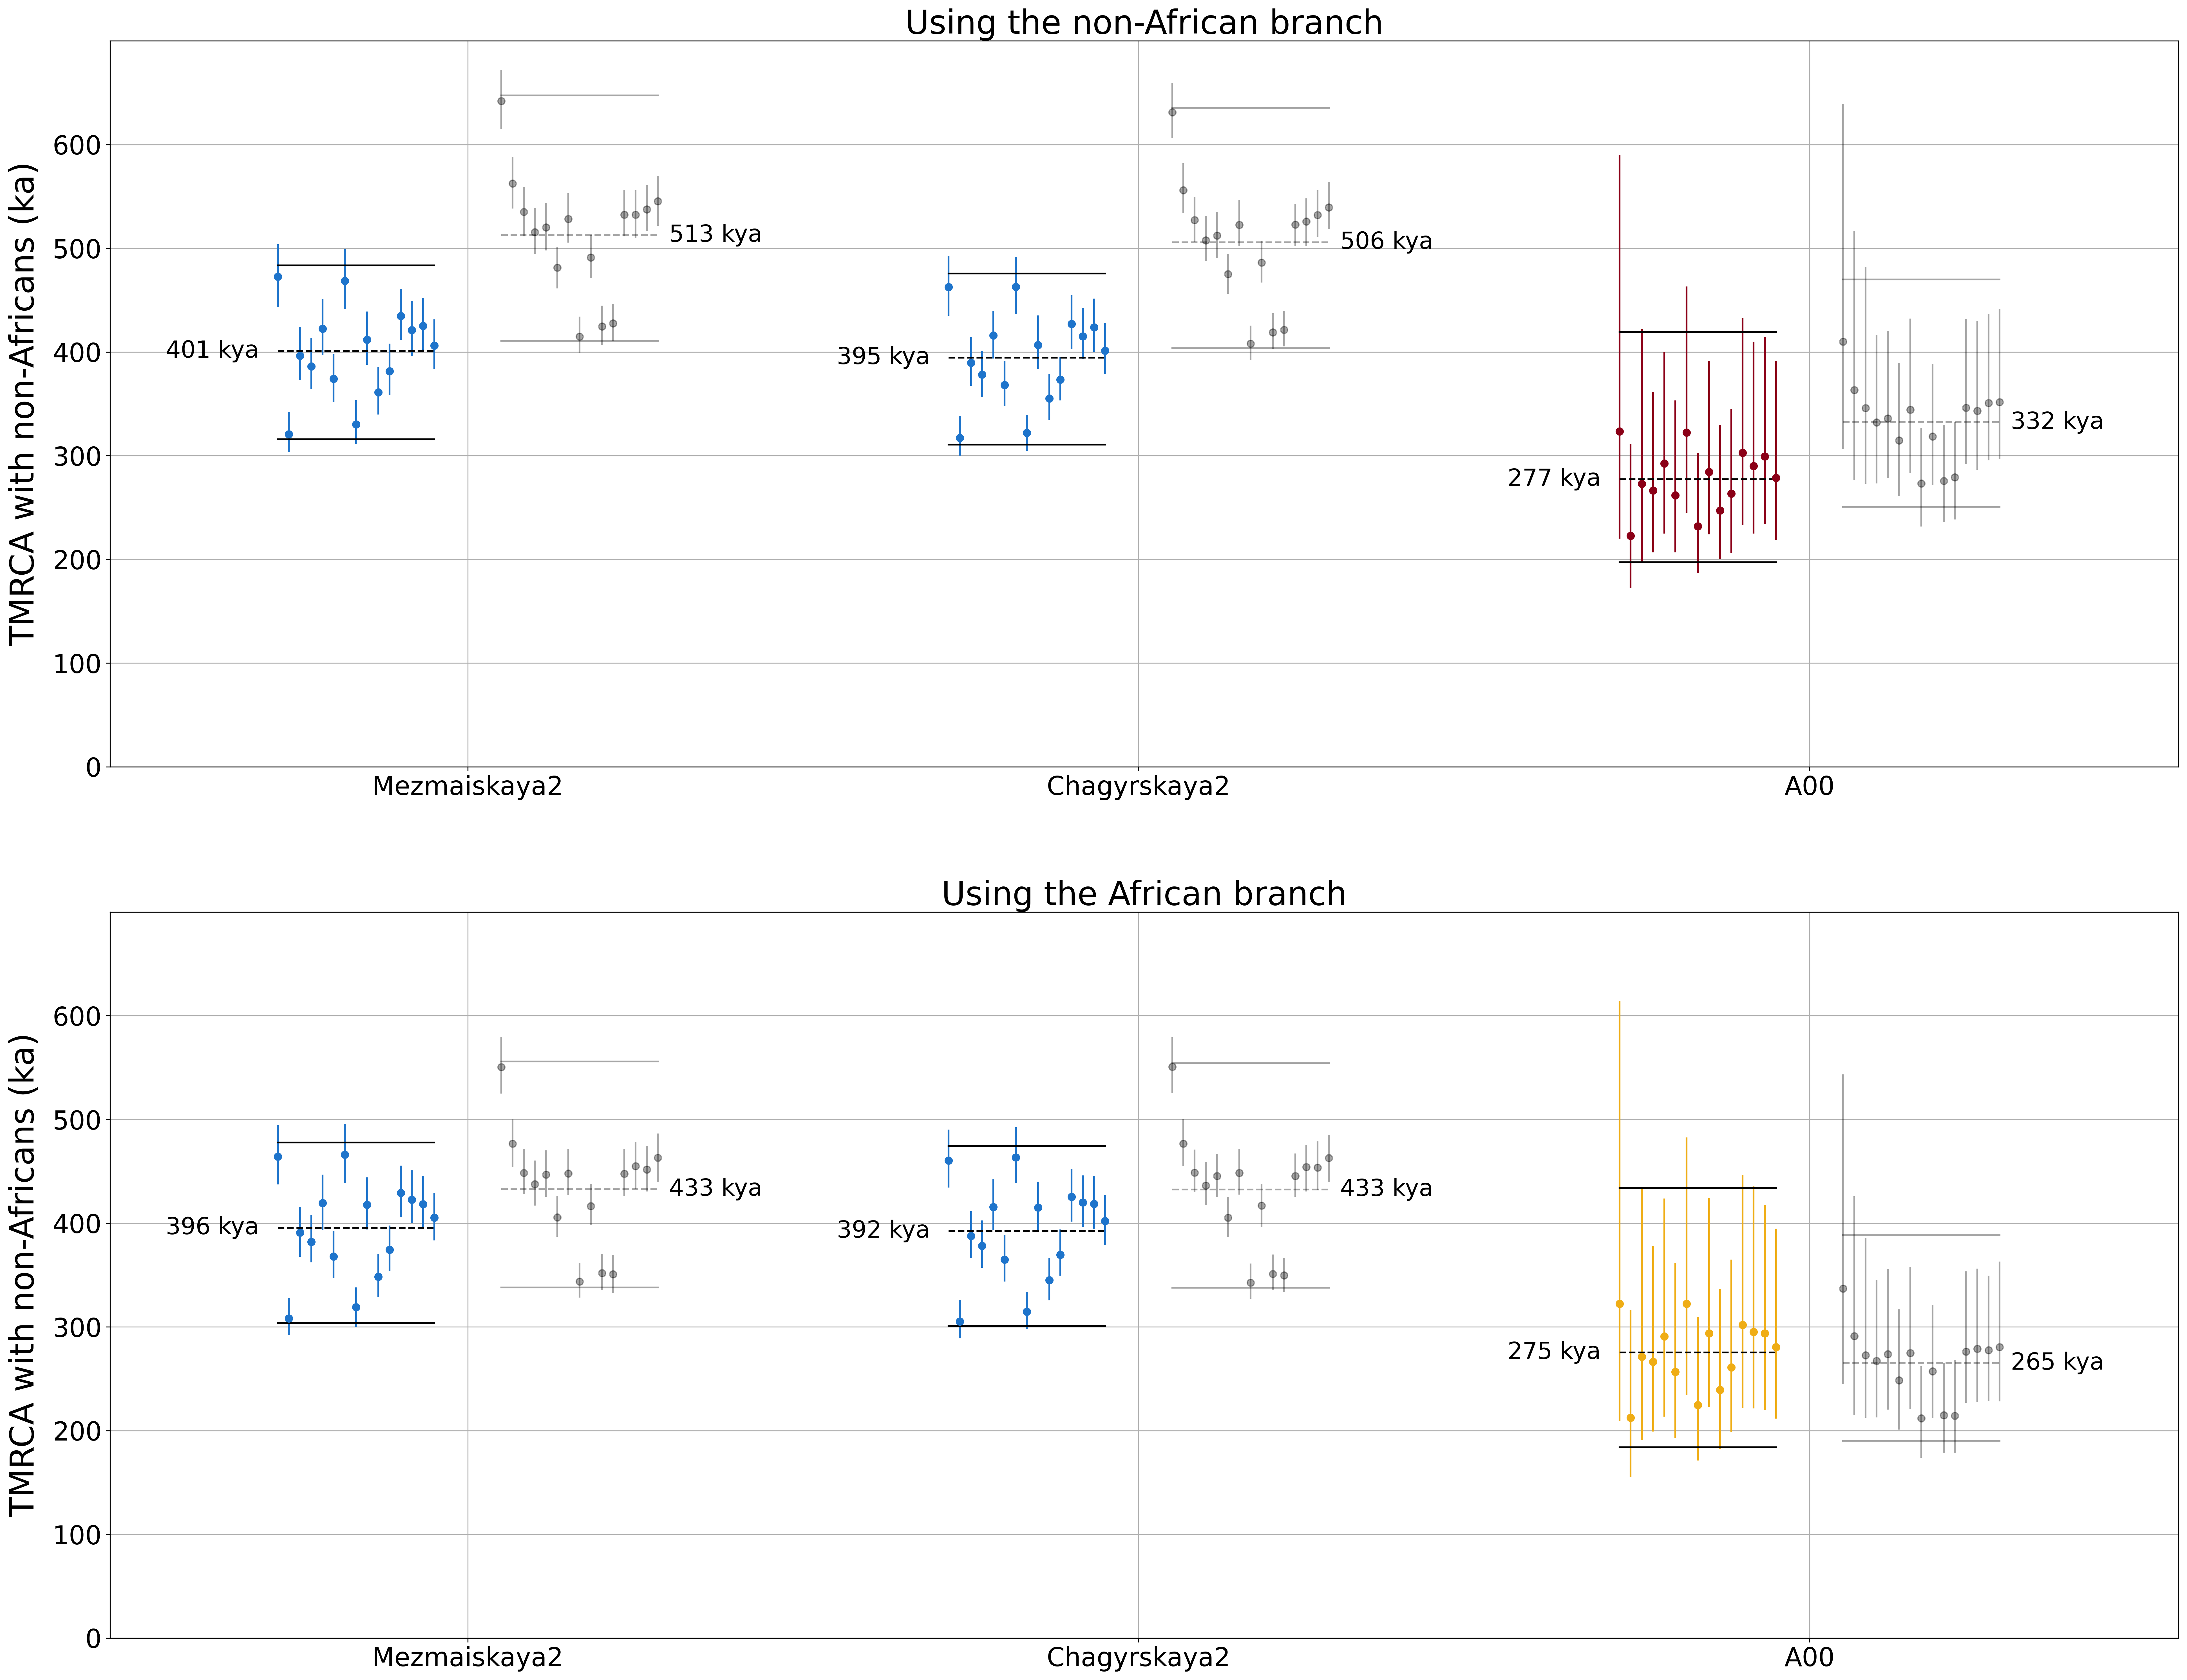

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle

def plot_tmrca_conf_intervals(ax, input, start, colour, text_side=1):
    import numpy as np

    lower_tmrca = np.array([val[1] for key, val in input.items() if key != 'total'])
    upper_tmrca = np.array([val[2] for key, val in input.items() if key != 'total'])
    mean_tmrca  = np.array([val[0] for key, val in input.items() if key != 'total'])
    x           = list(range(start, start + len(lower_tmrca), 1))
    label       = (start + len(lower_tmrca)//2)

    if text_side == 0:
        txt_x       = start - len(lower_tmrca) + 5
    else:
        txt_x       = start + len(lower_tmrca)

    txt_y       = input['total'][0]

    if colour != 'k':
        ax.errorbar(x, mean_tmrca, yerr=(mean_tmrca - lower_tmrca, upper_tmrca - mean_tmrca), ls='None', marker='o', lw=1.5, markersize=6, color=colour)
        ax.text(txt_x, txt_y, str(int(round(input['total'][0], -3)/1000)) + ' kya', va='center', fontsize=20) 
        ax.plot((start, start + len(lower_tmrca) - 1), (input['total'][1], input['total'][1]), 'k-', lw=1.5)
        ax.plot((start, start + len(lower_tmrca) - 1), (input['total'][2], input['total'][2]), 'k-', lw=1.5)
        ax.plot((start, start + len(lower_tmrca) - 1), (input['total'][0], input['total'][0]), 'k--', lw=1.5)
    else:
        ax.errorbar(x, mean_tmrca, yerr=(mean_tmrca - lower_tmrca, upper_tmrca - mean_tmrca), ls='None', marker='o', lw=1.5, markersize=6, color=colour, alpha=0.35)
        ax.text(txt_x, txt_y, str(int(round(input['total'][0], -3)/1000)) + ' kya', va='center', fontsize=20) 
        ax.plot((start, start + len(lower_tmrca) - 1), (input['total'][1], input['total'][1]), 'k-', lw=1.5, alpha=0.35)
        ax.plot((start, start + len(lower_tmrca) - 1), (input['total'][2], input['total'][2]), 'k-', lw=1.5, alpha=0.35)
        ax.plot((start, start + len(lower_tmrca) - 1), (input['total'][0], input['total'][0]), 'k--', lw=1.5, alpha=0.35)

    return label

mpl.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (26,20))

tmrca_afr_filtered = pickle.load(open('data/output_data/tmrca_A00_non_africans_filtered.pkl', 'rb'))
tmrca_afr = pickle.load(open('data/output_data/tmrca_A00_non_africans.pkl', 'rb'))

tmrca_mez2_filtered = pickle.load(open('data/output_data/tmrca_mez2_A00_non_africans_filtered.pkl', 'rb'))
tmrca_chag2_filtered = pickle.load(open('data/output_data/tmrca_chag2_A00_non_africans_filtered.pkl', 'rb'))

tmrca_mez2 = pickle.load(open('data/output_data/tmrca_mez2_A00_non_africans.pkl', 'rb'))
tmrca_chag2 = pickle.load(open('data/output_data/tmrca_chag2_A00_non_africans.pkl', 'rb'))

plot_tmrca_conf_intervals(ax[0], tmrca_mez2_filtered['tmrca_arch_non_african_branch'], 0, '#1E74CB', 0)
plot_tmrca_conf_intervals(ax[0], tmrca_chag2_filtered['tmrca_arch_non_african_branch'], 60, '#1E74CB', 0)
plot_tmrca_conf_intervals(ax[0], tmrca_afr_filtered['tmrca_mh_non_african_branch'], 120, '#8B0017', 0)

plot_tmrca_conf_intervals(ax[0], tmrca_mez2['tmrca_arch_non_african_branch'], 20, 'k')
plot_tmrca_conf_intervals(ax[0], tmrca_chag2['tmrca_arch_non_african_branch'], 80, 'k')
plot_tmrca_conf_intervals(ax[0], tmrca_afr['tmrca_mh_non_african_branch'], 140, 'k')

plot_tmrca_conf_intervals(ax[1], tmrca_mez2_filtered['tmrca_arch_african_branch'], 0, '#1E74CB', 0)
plot_tmrca_conf_intervals(ax[1], tmrca_chag2_filtered['tmrca_arch_african_branch'], 60, '#1E74CB', 0)
plot_tmrca_conf_intervals(ax[1], tmrca_afr_filtered['tmrca_mh_african_branch'], 120, '#EFAD15', 0)

plot_tmrca_conf_intervals(ax[1], tmrca_mez2['tmrca_arch_african_branch'], 20, 'k')
plot_tmrca_conf_intervals(ax[1], tmrca_chag2['tmrca_arch_african_branch'], 80, 'k')
plot_tmrca_conf_intervals(ax[1], tmrca_afr['tmrca_mh_african_branch'], 140, 'k')

ax[0].set_ylim([0, 700000])
ax[0].set_xlim([-15, 170])
ax[0].set_ylabel('TMRCA with non-Africans (ka)', fontsize=28, labelpad=10)
ax[0].set_xticks([17, 77, 137], ['Mezmaiskaya2', 'Chagyrskaya2', 'A00'])
ax[0].set_yticks(range(0, 700000, 100000))
ax[0].grid()
ax[0].ticklabel_format(style='plain', useOffset=False, axis='y')
ax[0].set_title('Using the non-African branch', fontsize=28)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_yticklabels(['0', '100', '200', '300', '400', '500', '600'])

ax[1].set_ylim([0, 700000])
ax[1].set_xlim([-15, 170])
ax[1].set_ylabel('TMRCA with non-Africans (ka)', fontsize=28, labelpad=10)
ax[1].set_xticks([17, 77, 137], ['Mezmaiskaya2', 'Chagyrskaya2', 'A00'])
ax[1].set_yticks(range(0, 700000, 100000))
ax[1].grid()
ax[1].ticklabel_format(style='plain', useOffset=False, axis='y')
ax[1].set_title('Using the African branch', fontsize=28)
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].set_yticklabels(['0', '100', '200', '300', '400', '500', '600'])

fig.tight_layout()
plt.subplots_adjust(hspace = 0.2)